# K ближайших соседей (KNN) — Классификация болезни Паркинсона

Метод K ближайших соседей (K-Nearest Neighbors, KNN) — это один из простейших и интуитивно понятных алгоритмов машинного обучения, используемый для задач классификации и регрессии. Принцип его работы заключается в следующем: для классификации нового объекта алгоритм находит K ближайших к нему объектов из обучающей выборки (соседей) по некоторой метрике расстояния (чаще всего евклидово расстояние) и присваивает новому объекту тот класс, который наиболее часто встречается среди этих K соседей. KNN является «ленивым» алгоритмом — он не строит явную модель во время обучения, а запоминает все обучающие данные и выполняет вычисления только в момент предсказания.

## Используемые библиотеки

In [145]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    classification_report,
    roc_curve,
    roc_auc_score,
    ConfusionMatrixDisplay
)

import warnings
warnings.filterwarnings('ignore')

plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 12

## Описание и загрузка датасета

https://www.kaggle.com/datasets/vikasukani/parkinsons-disease-data-set

### Краткое описание

Датасет содержит биомедицинские голосовые измерения 31 пациента, из которых 23 страдают болезнью Паркинсона. Записи голоса обработаны и представлены в виде числовых характеристик, описывающих частотные и амплитудные свойства речи. Используется для бинарной классификации — определения наличия заболевания по голосу.

### Признаки

| Признак | Описание |
|---------|----------|
| `name` | Идентификатор пациента и номер записи (не используется в модели) |
| `MDVP:Fo(Hz)` | Средняя основная частота голоса (в Гц) |
| `MDVP:Fhi(Hz)` | Максимальная основная частота голоса (в Гц) |
| `MDVP:Flo(Hz)` | Минимальная основная частота голоса (в Гц) |
| `MDVP:Jitter(%)` | Процентное отклонение периода основного тона (микровариации частоты) |
| `MDVP:Jitter(Abs)` | Абсолютное отклонение периода основного тона (в секундах) |
| `MDVP:RAP` | Relative Average Perturbation — относительное среднее возмущение частоты |
| `MDVP:PPQ` | Five-point Period Perturbation Quotient — пятиточечный коэффициент возмущения периода |
| `Jitter:DDP` | Среднее абсолютное различие последовательных разностей периодов (= RAP × 3) |
| `MDVP:Shimmer` | Локальное отклонение амплитуды голосового сигнала |
| `MDVP:Shimmer(dB)` | То же в децибелах |
| `Shimmer:APQ3` | Трёхточечный коэффициент возмущения амплитуды |
| `Shimmer:APQ5` | Пятиточечный коэффициент возмущения амплитуды |
| `MDVP:APQ` | 11-точечный коэффициент возмущения амплитуды |
| `Shimmer:DDA` | Среднее абсолютное различие последовательных разностей амплитуд (= APQ3 × 3) |
| `NHR` | Noise-to-Harmonics Ratio — отношение шума к гармоникам |
| `HNR` | Harmonics-to-Noise Ratio — отношение гармоник к шуму (в дБ) |
| `RPDE` | Recurrence Period Density Entropy — энтропия плотности периода повторения (нелинейная мера сложности) |
| `DFA` | Detrended Fluctuation Analysis — показатель фрактального масштабирования сигнала |
| `spread1` | Нелинейная мера вариации основной частоты (первая компонента) |
| `spread2` | Нелинейная мера вариации основной частоты (вторая компонента) |
| `D2` | Корреляционная размерность — нелинейная мера сложности динамической системы |
| `PPE` | Pitch Period Entropy — энтропия периода основного тона |

### Целевая переменная

| Переменная | Описание |
|------------|----------|
| `status` | **1** — пациент болен болезнью Паркинсона, **0** — здоров |

In [ ]:
# Загрузка датасета
df = pd.read_csv('parkinsons.data')

print("=" * 60)
print("ОБЩАЯ ИНФОРМАЦИЯ О ДАТАСЕТЕ")
print("=" * 60)
print(f"\nРазмер датасета: {df.shape[0]} строк, {df.shape[1]} столбцов")
print(f"\nПервые 5 строк:")
df.head()

ОБЩАЯ ИНФОРМАЦИЯ О ДАТАСЕТЕ

Размер датасета: 195 строк, 24 столбцов

Первые 5 строк:


,name,MDVP:Fo(Hz),MDVP:Fhi(Hz),MDVP:Flo(Hz),MDVP:Jitter(%),MDVP:Jitter(Abs),MDVP:RAP,MDVP:PPQ,Jitter:DDP,MDVP:Shimmer,...,Shimmer:DDA,NHR,HNR,status,RPDE,DFA,spread1,spread2,D2,PPE
0,phon_R01_S01_1,119.992,157.302,74.997,0.00784,0.00007,0.00370,0.00554,0.01109,0.04374,...,0.06545,0.02211,21.033,1,0.414783,0.815285,-4.813031,0.266482,2.301442,0.284654
1,phon_R01_S01_2,122.400,148.650,113.819,0.00968,0.00008,0.00465,0.00696,0.01394,0.06134,...,0.09403,0.01929,19.085,1,0.458359,0.819521,-4.075192,0.335590,2.486855,0.368674
2,phon_R01_S01_3,116.682,131.111,111.555,0.01050,0.00009,0.00544,0.00781,0.01633,0.05233,...,0.08270,0.01309,20.651,1,0.429895,0.825288,-4.443179,0.311173,2.342259,0.332634
3,phon_R01_S01_4,116.676,137.871,111.366,0.00997,0.00009,0.00502,0.00698,0.01505,0.05492,...,0.08771,0.01353,20.644,1,0.434969,0.819235,-4.117501,0.334147,2.405554,0.368975
4,phon_R01_S01_5,116.014,141.781,110.655,0.01284,0.00011,0.00655,0.00908,0.01966,0.06425,...,0.10470,0.01767,19.649,1,0.417356,0.823484,-3.747787,0.234513,2.332180,0.410335


In [147]:
print("\nИнформация о типах данных и пропусках:")
print("-" * 40)
df.info()


Информация о типах данных и пропусках:
----------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 195 entries, 0 to 194
Data columns (total 24 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   name              195 non-null    object 
 1   MDVP:Fo(Hz)       195 non-null    float64
 2   MDVP:Fhi(Hz)      195 non-null    float64
 3   MDVP:Flo(Hz)      195 non-null    float64
 4   MDVP:Jitter(%)    195 non-null    float64
 5   MDVP:Jitter(Abs)  195 non-null    float64
 6   MDVP:RAP          195 non-null    float64
 7   MDVP:PPQ          195 non-null    float64
 8   Jitter:DDP        195 non-null    float64
 9   MDVP:Shimmer      195 non-null    float64
 10  MDVP:Shimmer(dB)  195 non-null    float64
 11  Shimmer:APQ3      195 non-null    float64
 12  Shimmer:APQ5      195 non-null    float64
 13  MDVP:APQ          195 non-null    float64
 14  Shimmer:DDA       195 non-null    float64
 15  NHR       

In [148]:
print("\nСтатистическое описание числовых признаков:")
df.describe().round(3)


Статистическое описание числовых признаков:


,MDVP:Fo(Hz),MDVP:Fhi(Hz),MDVP:Flo(Hz),MDVP:Jitter(%),MDVP:Jitter(Abs),MDVP:RAP,MDVP:PPQ,Jitter:DDP,MDVP:Shimmer,MDVP:Shimmer(dB),...,Shimmer:DDA,NHR,HNR,status,RPDE,DFA,spread1,spread2,D2,PPE
count,195.000,195.000,195.000,195.000,195.0,195.000,195.000,195.000,195.000,195.000,...,195.000,195.000,195.000,195.000,195.000,195.000,195.000,195.000,195.000,195.000
mean,154.229,197.105,116.325,0.006,0.0,0.003,0.003,0.010,0.030,0.282,...,0.047,0.025,21.886,0.754,0.499,0.718,-5.684,0.227,2.382,0.207
std,41.390,91.492,43.521,0.005,0.0,0.003,0.003,0.009,0.019,0.195,...,0.030,0.040,4.426,0.432,0.104,0.055,1.090,0.083,0.383,0.090
min,88.333,102.145,65.476,0.002,0.0,0.001,0.001,0.002,0.010,0.085,...,0.014,0.001,8.441,0.000,0.257,0.574,-7.965,0.006,1.423,0.045
25%,117.572,134.862,84.291,0.003,0.0,0.002,0.002,0.005,0.017,0.148,...,0.025,0.006,19.198,1.000,0.421,0.675,-6.450,0.174,2.099,0.137
50%,148.790,175.829,104.315,0.005,0.0,0.002,0.003,0.007,0.023,0.221,...,0.038,0.012,22.085,1.000,0.496,0.722,-5.721,0.219,2.362,0.194
75%,182.769,224.206,140.019,0.007,0.0,0.004,0.004,0.012,0.038,0.350,...,0.061,0.026,25.075,1.000,0.588,0.762,-5.046,0.279,2.636,0.253
max,260.105,592.030,239.170,0.033,0.0,0.021,0.020,0.064,0.119,1.302,...,0.169,0.315,33.047,1.000,0.685,0.825,-2.434,0.450,3.671,0.527


In [149]:
print("\nПроверка пропущенных значений:")
print("-" * 40)
print(df.isnull().sum())
print(f"\nОбщее количество пропусков: {df.isnull().sum().sum()}")


Проверка пропущенных значений:
----------------------------------------
name                0
MDVP:Fo(Hz)         0
MDVP:Fhi(Hz)        0
MDVP:Flo(Hz)        0
MDVP:Jitter(%)      0
MDVP:Jitter(Abs)    0
MDVP:RAP            0
MDVP:PPQ            0
Jitter:DDP          0
MDVP:Shimmer        0
MDVP:Shimmer(dB)    0
Shimmer:APQ3        0
Shimmer:APQ5        0
MDVP:APQ            0
Shimmer:DDA         0
NHR                 0
HNR                 0
status              0
RPDE                0
DFA                 0
spread1             0
spread2             0
D2                  0
PPE                 0
dtype: int64

Общее количество пропусков: 0



Распределение целевой переменной 'status':
----------------------------------------
status
1    147
0     48
Name: count, dtype: int64

Доля больных (status=1): 75.38%
Доля здоровых (status=0): 24.62%


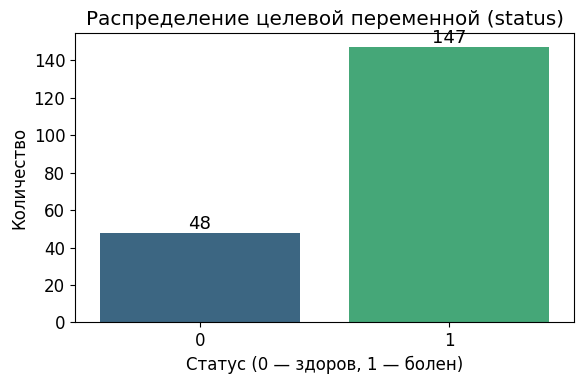

In [150]:
print("\nРаспределение целевой переменной 'status':")
print("-" * 40)
print(df['status'].value_counts())
print(f"\nДоля больных (status=1): {df['status'].mean():.2%}")
print(f"Доля здоровых (status=0): {1 - df['status'].mean():.2%}")

plt.figure(figsize=(6, 4))
ax = sns.countplot(x='status', data=df, palette='viridis')
plt.title('Распределение целевой переменной (status)')
plt.xlabel('Статус (0 — здоров, 1 — болен)')
plt.ylabel('Количество')
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='bottom', fontsize=13)
plt.tight_layout()
plt.show()

## Предварительная обработка датасета

In [151]:
print("=" * 60)
print("ПРЕДВАРИТЕЛЬНАЯ ОБРАБОТКА ДАННЫХ")
print("=" * 60)

# Удаляем столбец 'name' — это идентификатор, не признак
df_clean = df.drop(columns=['name'])
print(f"\nУдалён столбец 'name'.")
print(f"Размер после удаления: {df_clean.shape}")

# Проверка дубликатов
duplicates = df_clean.duplicated().sum()
print(f"\nКоличество дубликатов: {duplicates}")
if duplicates > 0:
    df_clean = df_clean.drop_duplicates()
    print(f"Дубликаты удалены. Новый размер: {df_clean.shape}")

ПРЕДВАРИТЕЛЬНАЯ ОБРАБОТКА ДАННЫХ

Удалён столбец 'name'.
Размер после удаления: (195, 23)

Количество дубликатов: 0


In [152]:
# Разделение на признаки и целевую переменную
X = df_clean.drop(columns=['status'])
y = df_clean['status']

print(f"\nРазмер матрицы признаков X: {X.shape}")
print(f"Размер вектора целевой переменной y: {y.shape}")
print(f"\nНазвания признаков ({len(X.columns)} шт.):")
for i, col in enumerate(X.columns, 1):
    print(f"  {i:2d}. {col}")


Размер матрицы признаков X: (195, 22)
Размер вектора целевой переменной y: (195,)

Названия признаков (22 шт.):
   1. MDVP:Fo(Hz)
   2. MDVP:Fhi(Hz)
   3. MDVP:Flo(Hz)
   4. MDVP:Jitter(%)
   5. MDVP:Jitter(Abs)
   6. MDVP:RAP
   7. MDVP:PPQ
   8. Jitter:DDP
   9. MDVP:Shimmer
  10. MDVP:Shimmer(dB)
  11. Shimmer:APQ3
  12. Shimmer:APQ5
  13. MDVP:APQ
  14. Shimmer:DDA
  15. NHR
  16. HNR
  17. RPDE
  18. DFA
  19. spread1
  20. spread2
  21. D2
  22. PPE


In [153]:
# Разделение на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"\nРазмер обучающей выборки: {X_train.shape[0]} ({X_train.shape[0]/len(X):.1%})")
print(f"Размер тестовой выборки:  {X_test.shape[0]} ({X_test.shape[0]/len(X):.1%})")
print(f"\nРаспределение классов в обучающей выборке:")
print(y_train.value_counts())
print(f"\nРаспределение классов в тестовой выборке:")
print(y_test.value_counts())


Размер обучающей выборки: 156 (80.0%)
Размер тестовой выборки:  39 (20.0%)

Распределение классов в обучающей выборке:
status
1    118
0     38
Name: count, dtype: int64

Распределение классов в тестовой выборке:
status
1    29
0    10
Name: count, dtype: int64


In [154]:
# Масштабирование признаков
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("\nМасштабирование выполнено (StandardScaler).")
print(f"\nСреднее значение признаков до масштабирования (первые 5):")
print(np.round(X_train.mean().head(), 3))
print(f"\nСреднее значение признаков после масштабирования (первые 5):")
print(np.round(pd.DataFrame(X_train_scaled, columns=X.columns).mean().head(), 6))


Масштабирование выполнено (StandardScaler).

Среднее значение признаков до масштабирования (первые 5):
MDVP:Fo(Hz)         153.435
MDVP:Fhi(Hz)        194.788
MDVP:Flo(Hz)        114.139
MDVP:Jitter(%)        0.006
MDVP:Jitter(Abs)      0.000
dtype: float64

Среднее значение признаков после масштабирования (первые 5):
MDVP:Fo(Hz)        -0.0
MDVP:Fhi(Hz)        0.0
MDVP:Flo(Hz)        0.0
MDVP:Jitter(%)     -0.0
MDVP:Jitter(Abs)   -0.0
dtype: float64


## Тепловая карта корреляций (Heatmap)

ТЕПЛОВАЯ КАРТА КОРРЕЛЯЦИЙ


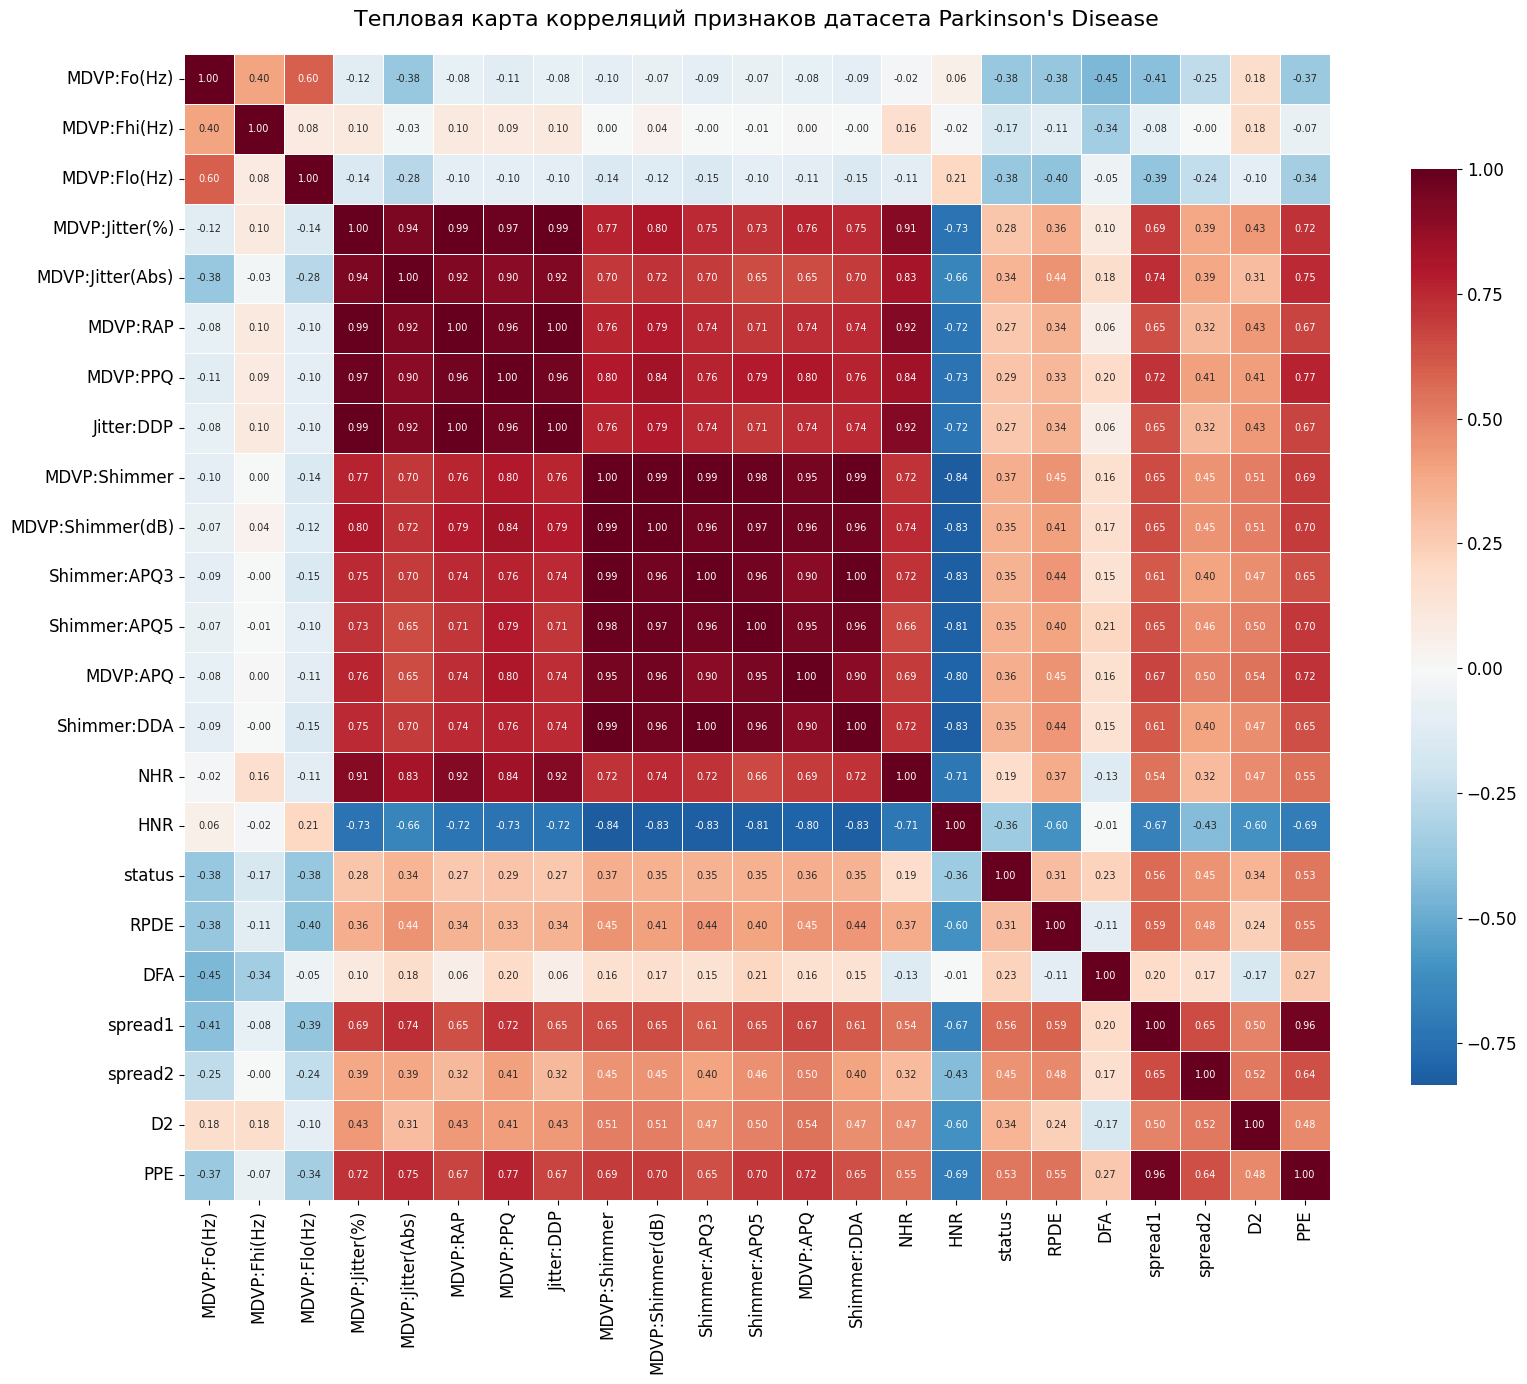

In [155]:
print("=" * 60)
print("ТЕПЛОВАЯ КАРТА КОРРЕЛЯЦИЙ")
print("=" * 60)

plt.figure(figsize=(18, 14))
correlation_matrix = df_clean.corr()

sns.heatmap(
    correlation_matrix,
    annot=True,
    fmt='.2f',
    cmap='RdBu_r',
    center=0,
    square=True,
    linewidths=0.5,
    cbar_kws={"shrink": 0.8},
    annot_kws={"size": 7}
)
plt.title('Тепловая карта корреляций признаков датасета Parkinson\'s Disease', fontsize=16, pad=20)
plt.tight_layout()
plt.show()


Корреляция признаков с целевой переменной 'status':
--------------------------------------------------
spread1             0.565
PPE                 0.531
spread2             0.455
MDVP:Shimmer        0.367
MDVP:APQ            0.364
Shimmer:APQ5        0.351
MDVP:Shimmer(dB)    0.351
Shimmer:APQ3        0.348
Shimmer:DDA         0.348
D2                  0.340
MDVP:Jitter(Abs)    0.339
RPDE                0.309
MDVP:PPQ            0.289
MDVP:Jitter(%)      0.278
MDVP:RAP            0.267
Jitter:DDP          0.267
DFA                 0.232
NHR                 0.189
MDVP:Fhi(Hz)       -0.166
HNR                -0.362
MDVP:Flo(Hz)       -0.380
MDVP:Fo(Hz)        -0.384
Name: status, dtype: float64


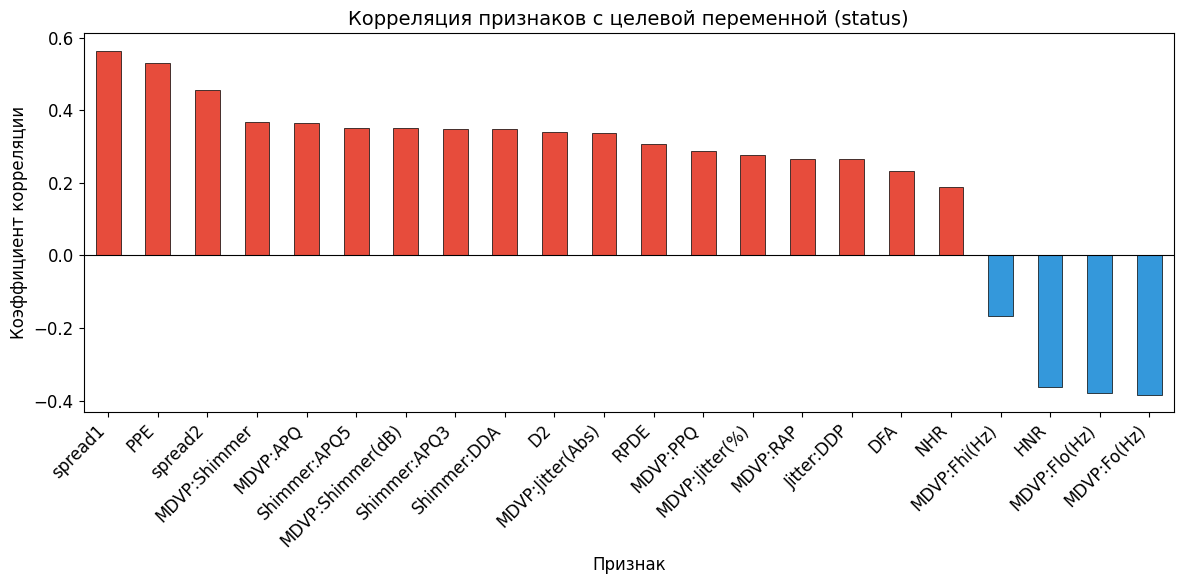

In [156]:
# Корреляция признаков с целевой переменной
print("\nКорреляция признаков с целевой переменной 'status':")
print("-" * 50)
corr_with_target = correlation_matrix['status'].drop('status').sort_values(ascending=False)
print(corr_with_target.round(3))

# Визуализация корреляции с целевой переменной
plt.figure(figsize=(12, 6))
colors = ['#e74c3c' if v > 0 else '#3498db' for v in corr_with_target.values]
corr_with_target.plot(kind='bar', color=colors, edgecolor='black', linewidth=0.5)
plt.title('Корреляция признаков с целевой переменной (status)', fontsize=14)
plt.xlabel('Признак')
plt.ylabel('Коэффициент корреляции')
plt.axhline(y=0, color='black', linewidth=0.8)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

## Обучение модели

In [177]:
print("=" * 60)
print("ОБУЧЕНИЕ МОДЕЛИ KNN")
print("=" * 60)

# Подбор оптимального значения K с помощью GridSearchCV
param_grid = {
    'n_neighbors': list(range(1, 31)),
    'weights': ['uniform', 'distance'],
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
    'metric': ['euclidean', 'manhattan', 'minkowski', 'cityblock', 'cosine', 'haversine', 'nan_euclidean', 'l1', 'l2']
}

knn = KNeighborsClassifier(n_jobs=-1)

grid_search = GridSearchCV(
    estimator=knn,
    param_grid=param_grid,
    cv=3,
    scoring='f1',
    n_jobs=-1,
    verbose=0
)

grid_search.fit(X_train_scaled, y_train)

print(f"\nЛучшие параметры: {grid_search.best_params_}")
print(f"Лучший F1-score (кросс-валидация): {grid_search.best_score_:.4f}")

best_knn = grid_search.best_estimator_

ОБУЧЕНИЕ МОДЕЛИ KNN

Лучшие параметры: {'algorithm': 'auto', 'metric': 'cosine', 'n_neighbors': 26, 'weights': 'distance'}
Лучший F1-score (кросс-валидация): 0.9460


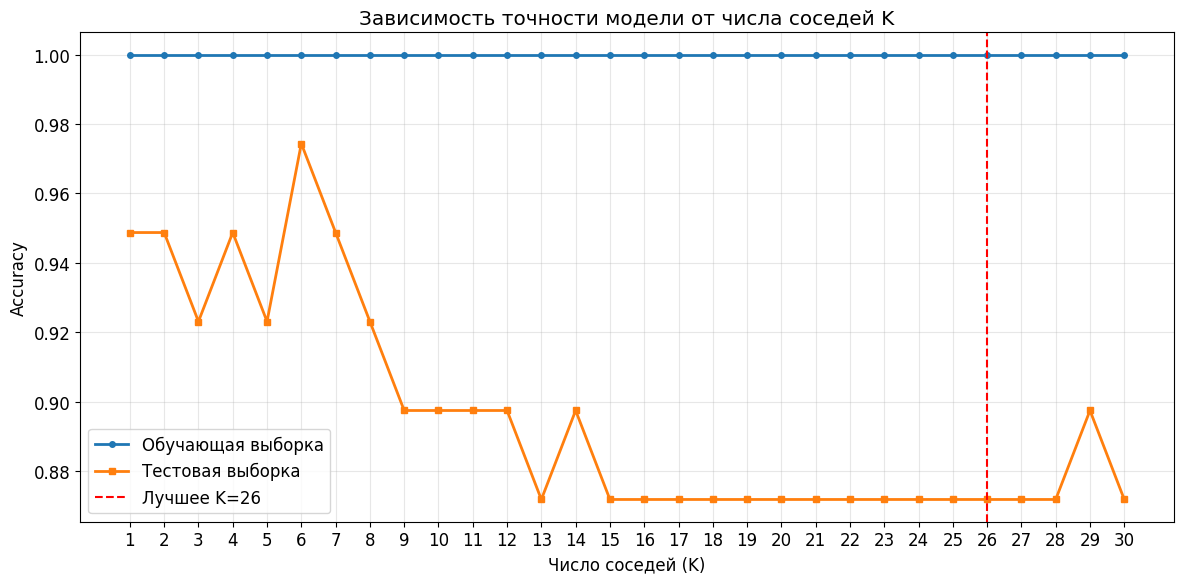

In [178]:
# Визуализация зависимости точности от числа соседей K
k_range = range(1, 31)
train_scores = []
test_scores = []

for k in k_range:
    knn_temp = KNeighborsClassifier(
        n_neighbors=k,
        weights=grid_search.best_params_['weights'],
        metric=grid_search.best_params_['metric'],
        algorithm=grid_search.best_params_['algorithm']
    )
    knn_temp.fit(X_train_scaled, y_train)
    train_scores.append(knn_temp.score(X_train_scaled, y_train))
    test_scores.append(knn_temp.score(X_test_scaled, y_test))

plt.figure(figsize=(12, 6))
plt.plot(k_range, train_scores, 'o-', label='Обучающая выборка', linewidth=2, markersize=4)
plt.plot(k_range, test_scores, 's-', label='Тестовая выборка', linewidth=2, markersize=4)
plt.axvline(x=grid_search.best_params_['n_neighbors'], color='red',
            linestyle='--', label=f'Лучшее K={grid_search.best_params_["n_neighbors"]}')
plt.xlabel('Число соседей (K)')
plt.ylabel('Accuracy')
plt.title('Зависимость точности модели от числа соседей K')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(k_range)
plt.tight_layout()
plt.show()

## Прогнозы модели

In [179]:
print("=" * 60)
print("ПРОГНОЗЫ МОДЕЛИ")
print("=" * 60)

# Предсказания на тестовой выборке
y_pred = best_knn.predict(X_test_scaled)
y_pred_proba = best_knn.predict_proba(X_test_scaled)[:, 1]

# Таблица с результатами предсказаний
results = pd.DataFrame({
    'Истинное значение': y_test.values,
    'Предсказание': y_pred,
    'Вероятность (класс 1)': np.round(y_pred_proba, 4),
    'Верно': y_test.values == y_pred
})
results.index = range(1, len(results) + 1)
results.index.name = '№'

print("\nТаблица предсказаний (все объекты тестовой выборки):")
print("-" * 65)
print(results.to_string())

ПРОГНОЗЫ МОДЕЛИ

Таблица предсказаний (все объекты тестовой выборки):
-----------------------------------------------------------------
    Истинное значение  Предсказание  Вероятность (класс 1)  Верно
№                                                                
1                   0             1                 0.5533  False
2                   1             1                 0.5919   True
3                   1             1                 0.8954   True
4                   1             0                 0.4333  False
5                   0             0                 0.2120   True
6                   1             1                 1.0000   True
7                   1             1                 0.6146   True
8                   1             1                 0.6217   True
9                   0             0                 0.1133   True
10                  1             1                 0.8856   True
11                  1             1                 1.0000   True
12    

In [180]:
# Сводка по предсказаниям
correct = (y_test.values == y_pred).sum()
incorrect = (y_test.values != y_pred).sum()

print(f"\n{'='*40}")
print(f"Правильных предсказаний: {correct} из {len(y_test)} ({correct/len(y_test):.1%})")
print(f"Ошибочных предсказаний:  {incorrect} из {len(y_test)} ({incorrect/len(y_test):.1%})")

# Показать ошибочные предсказания
errors = results[results['Верно'] == False]
if len(errors) > 0:
    print(f"\nОшибочные предсказания:")
    print(errors)
else:
    print("\nМодель не допустила ошибок!")


Правильных предсказаний: 34 из 39 (87.2%)
Ошибочных предсказаний:  5 из 39 (12.8%)

Ошибочные предсказания:
    Истинное значение  Предсказание  Вероятность (класс 1)  Верно
№                                                                
1                   0             1                 0.5533  False
4                   1             0                 0.4333  False
12                  1             0                 0.4357  False
24                  0             1                 0.5273  False
34                  1             0                 0.4725  False


## Графики выходных результатов и метрики

In [181]:
print("=" * 60)
print("МЕТРИКИ КАЧЕСТВА МОДЕЛИ")
print("=" * 60)

# Вычисление метрик
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)

print(f"\n{'Метрика':<25} {'Значение':>10}")
print("-" * 37)
print(f"{'Accuracy (Точность)':<25} {accuracy:>10.4f}")
print(f"{'Precision (Точность+)':<25} {precision:>10.4f}")
print(f"{'Recall (Полнота)':<25} {recall:>10.4f}")
print(f"{'F1-score':<25} {f1:>10.4f}")
print(f"{'ROC-AUC':<25} {roc_auc:>10.4f}")

print(f"\n\nПодробный отчёт классификации:")
print("-" * 50)
print(classification_report(y_test, y_pred,
                            target_names=['Здоров (0)', 'Болен (1)']))

МЕТРИКИ КАЧЕСТВА МОДЕЛИ

Метрика                     Значение
-------------------------------------
Accuracy (Точность)           0.8718
Precision (Точность+)         0.9286
Recall (Полнота)              0.8966
F1-score                      0.9123
ROC-AUC                       0.9793


Подробный отчёт классификации:
--------------------------------------------------
              precision    recall  f1-score   support

  Здоров (0)       0.73      0.80      0.76        10
   Болен (1)       0.93      0.90      0.91        29

    accuracy                           0.87        39
   macro avg       0.83      0.85      0.84        39
weighted avg       0.88      0.87      0.87        39



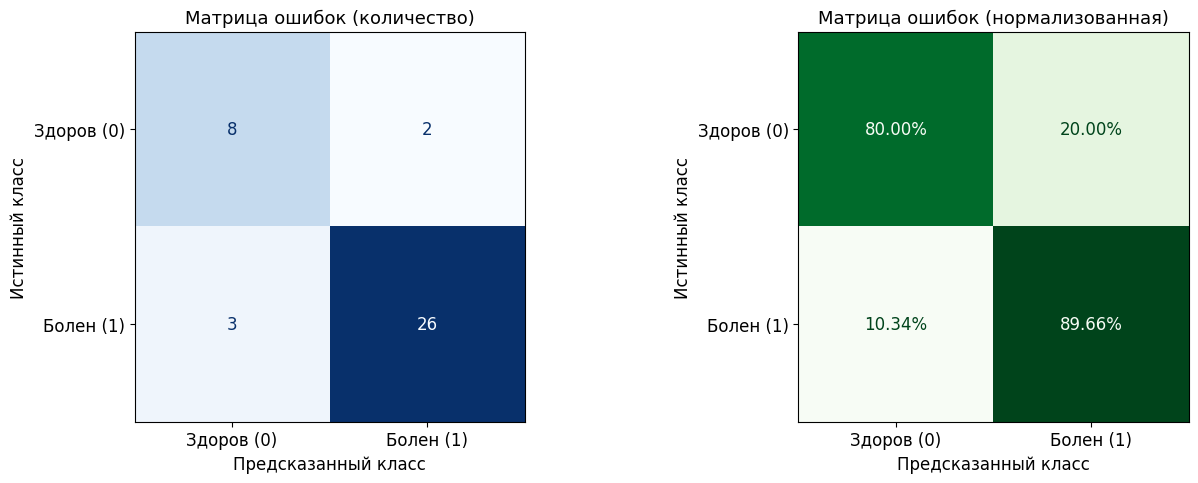


True Negatives (TN):  8
False Positives (FP): 2
False Negatives (FN): 3
True Positives (TP):  26


In [182]:
# 1. Матрица ошибок
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Матрица ошибок — числа
cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(cm, display_labels=['Здоров (0)', 'Болен (1)']).plot(
    ax=axes[0], cmap='Blues', colorbar=False
)
axes[0].set_title('Матрица ошибок (количество)', fontsize=13)
axes[0].set_xlabel('Предсказанный класс')
axes[0].set_ylabel('Истинный класс')

# Матрица ошибок — нормализованная
cm_norm = confusion_matrix(y_test, y_pred, normalize='true')
ConfusionMatrixDisplay(cm_norm, display_labels=['Здоров (0)', 'Болен (1)']).plot(
    ax=axes[1], cmap='Greens', colorbar=False, values_format='.2%'
)
axes[1].set_title('Матрица ошибок (нормализованная)', fontsize=13)
axes[1].set_xlabel('Предсказанный класс')
axes[1].set_ylabel('Истинный класс')

plt.tight_layout()
plt.show()

print(f"\nTrue Negatives (TN):  {cm[0][0]}")
print(f"False Positives (FP): {cm[0][1]}")
print(f"False Negatives (FN): {cm[1][0]}")
print(f"True Positives (TP):  {cm[1][1]}")

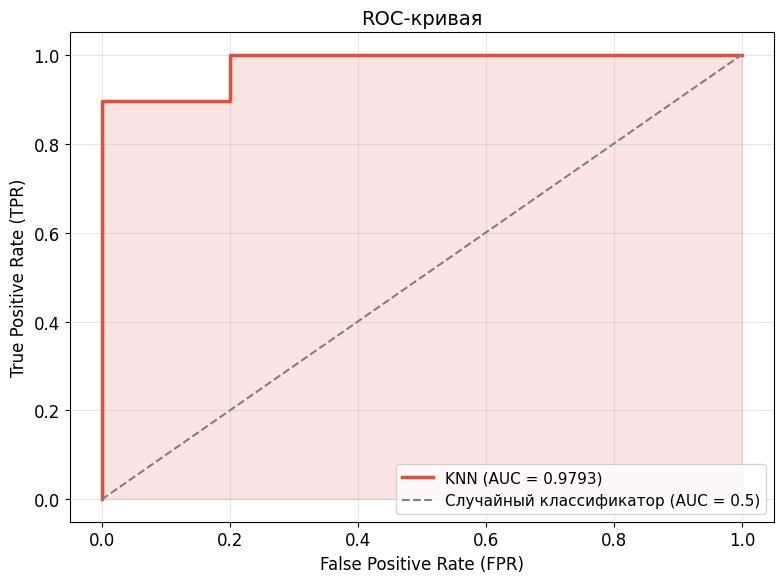

In [183]:
# 2. ROC-кривая
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='#e74c3c', linewidth=2.5,
         label=f'KNN (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', linewidth=1.5,
         label='Случайный классификатор (AUC = 0.5)')
plt.fill_between(fpr, tpr, alpha=0.15, color='#e74c3c')
plt.xlabel('False Positive Rate (FPR)', fontsize=12)
plt.ylabel('True Positive Rate (TPR)', fontsize=12)
plt.title('ROC-кривая', fontsize=14)
plt.legend(loc='lower right', fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

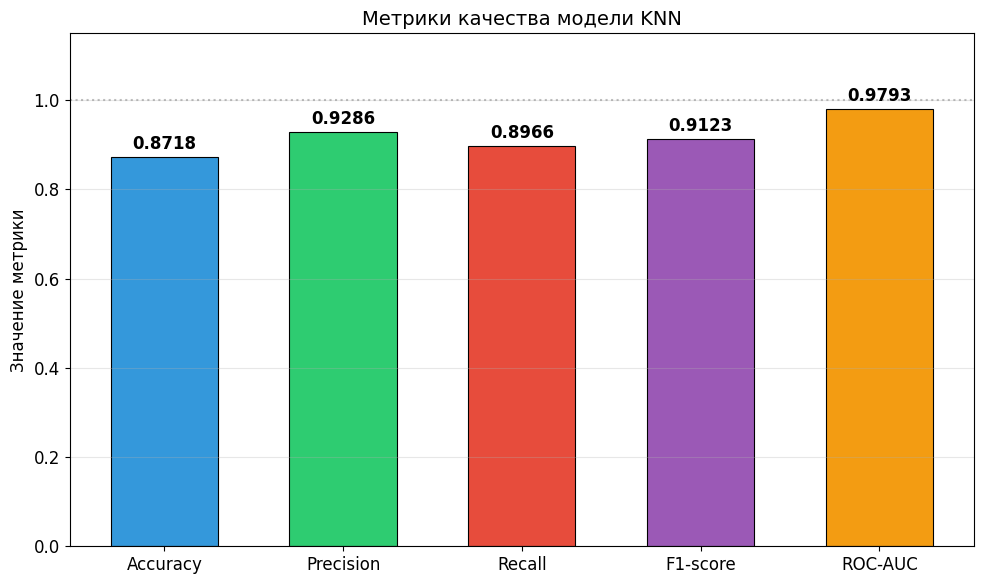

In [184]:
# 3. Столбчатая диаграмма метрик
metrics_names = ['Accuracy', 'Precision', 'Recall', 'F1-score', 'ROC-AUC']
metrics_values = [accuracy, precision, recall, f1, roc_auc]
colors = ['#3498db', '#2ecc71', '#e74c3c', '#9b59b6', '#f39c12']

plt.figure(figsize=(10, 6))
bars = plt.bar(metrics_names, metrics_values, color=colors, edgecolor='black',
               linewidth=0.8, width=0.6)
for bar, val in zip(bars, metrics_values):
    plt.text(bar.get_x() + bar.get_width() / 2., bar.get_height() + 0.01,
             f'{val:.4f}', ha='center', va='bottom', fontsize=12, fontweight='bold')

plt.ylim(0, 1.15)
plt.ylabel('Значение метрики', fontsize=12)
plt.title('Метрики качества модели KNN', fontsize=14)
plt.axhline(y=1.0, color='gray', linestyle=':', alpha=0.5)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

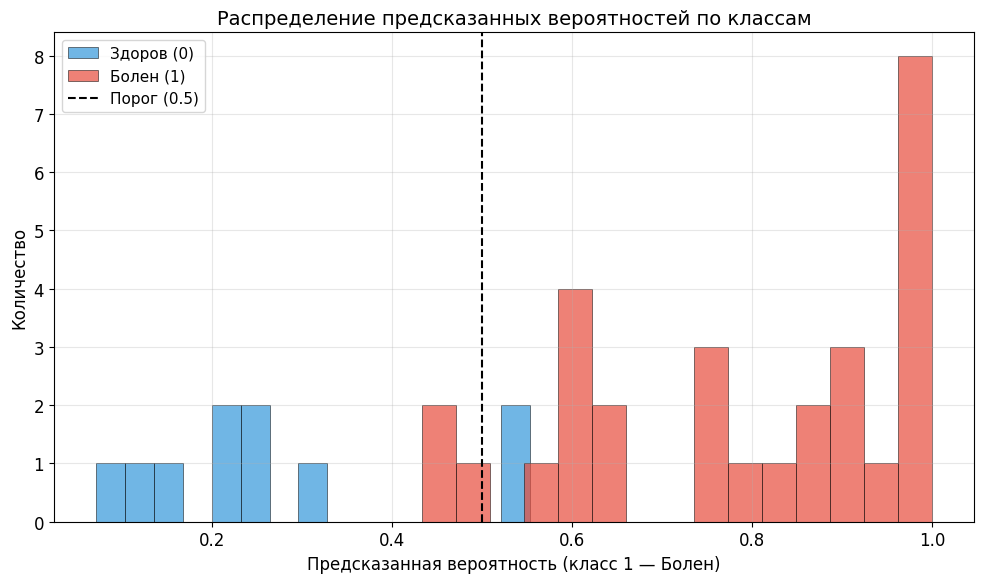

In [185]:
# 4. Распределение предсказанных вероятностей по классам
plt.figure(figsize=(10, 6))

plt.hist(y_pred_proba[y_test == 0], bins=15, alpha=0.7, color='#3498db',
         label='Здоров (0)', edgecolor='black', linewidth=0.5)
plt.hist(y_pred_proba[y_test == 1], bins=15, alpha=0.7, color='#e74c3c',
         label='Болен (1)', edgecolor='black', linewidth=0.5)
plt.axvline(x=0.5, color='black', linestyle='--', linewidth=1.5, label='Порог (0.5)')
plt.xlabel('Предсказанная вероятность (класс 1 — Болен)', fontsize=12)
plt.ylabel('Количество', fontsize=12)
plt.title('Распределение предсказанных вероятностей по классам', fontsize=14)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

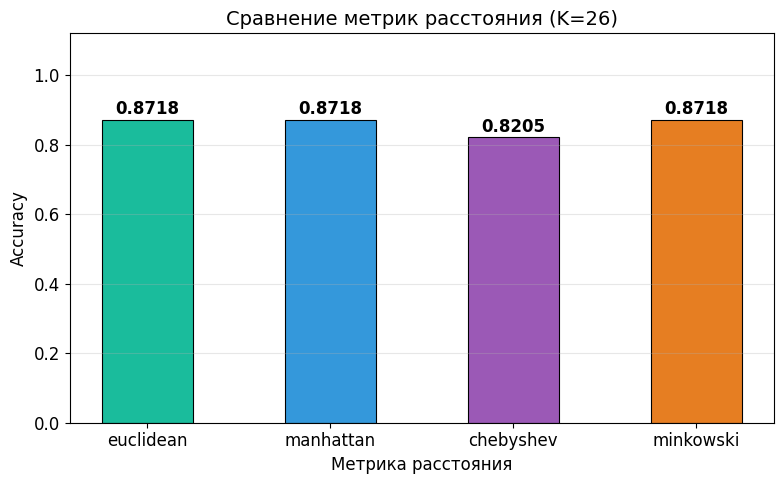

In [186]:
# 5. Сравнение точности для разных метрик расстояния при оптимальном K
best_k = grid_search.best_params_['n_neighbors']
distance_metrics = ['euclidean', 'manhattan', 'chebyshev', 'minkowski']
metric_results = {}

for metric in distance_metrics:
    try:
        knn_temp = KNeighborsClassifier(n_neighbors=best_k, weights='distance', metric=metric)
        knn_temp.fit(X_train_scaled, y_train)
        score = knn_temp.score(X_test_scaled, y_test)
        metric_results[metric] = score
    except Exception:
        pass

plt.figure(figsize=(8, 5))
bars = plt.bar(metric_results.keys(), metric_results.values(),
               color=['#1abc9c', '#3498db', '#9b59b6', '#e67e22'],
               edgecolor='black', linewidth=0.8, width=0.5)
for bar, val in zip(bars, metric_results.values()):
    plt.text(bar.get_x() + bar.get_width() / 2., bar.get_height() + 0.005,
             f'{val:.4f}', ha='center', va='bottom', fontsize=12, fontweight='bold')
plt.ylim(0, 1.12)
plt.ylabel('Accuracy', fontsize=12)
plt.xlabel('Метрика расстояния', fontsize=12)
plt.title(f'Сравнение метрик расстояния (K={best_k})', fontsize=14)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()